In [6]:
import matplotlib
from torch.optim import lr_scheduler, Adam

from braindecode.models import EEGNetv4,ATCNet

%matplotlib inline

import matplotlib.pyplot as plt
plt.ion()
import numpy as np
import cv2
import torch
from functools import partial
from datetime import datetime
import os
import numpy as np
from braindecode.datasets import (
    create_from_mne_raw, create_from_mne_epochs)
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)
import argparse
import json
import sys
sys.path.append("..") 
from nets.model import NeuroScribe
from load.load.data.data_loader import fif_txt_Loader




Define basic parameters

In [7]:

name='cnn-ndp-il'


neuros = 500   # 200 or 500
data_path1 = '../data/S1_Session1_3.fif'
data_path2 = '../data/S2_Session1_3.fif'
x_path='../data/x3.txt'
y_path='../data/y3.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Read data

In [16]:
if_sep=0
raw,  or_tr = fif_txt_Loader.load_data([data_path1],x_path,y_path,if_sep)
for i in range(748):
    or_tr[i]=or_tr[i]*20


# raw.filter(l_freq=8,h_freq=30)

lllllll
Reading /root/autodl-fs/AAAIProject/ndp/ndp_test/../data/S1_Session1_3.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    3999.00 ms
        0 CTF compensation matrices available


/root/autodl-fs/AAAIProject/imednet/imednet/data/data_loader.py:76: RuntimeWarning: This filename (../data/S1_Session1_3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs=mne.read_epochs(fileepoch[0])


Not setting metadata
748 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.3s
[Parallel(n_job

Processing data

In [11]:
raw_data = raw.get_data()
input_size = raw_data.shape[1] * raw_data.shape[2]

inds = np.arange(748)

test_inds = inds
# train_inds = inds[:700]
X = torch.Tensor(raw_data[:748]).float() 
Y = torch.Tensor(np.array(or_tr)[:, :, :2]).float()[:748]
X, Y = X.to(device), Y.to(device)


/tmp/ipykernel_1224/1547767485.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  raw_data = raw.get_data()


Define hyperparameters and read models

In [15]:
time = str(datetime.now())
time = time.replace(' ', '_')
time = time.replace(':', '_')
time = time.replace('-', '_')
time = time.replace('.', '_')
model_save_path = '../EEG_ndp_models/' + name
# hyper parameters
k = 1
T = 199 / k
N = 200
learning_rate = 0.001
num_epochs = 1
batch_size = 10

param_str = "T" + str(T) + "_K" + str(k) + "_N" + str(N) + "_L" + str(learning_rate) + "_E" + str(num_epochs) + "_B" + str(batch_size)
model_save_path = model_save_path + '_(' + param_str + ')_(' + time + ')'
os.mkdir(model_save_path)

image_save_path = model_save_path + '/images'
os.mkdir(image_save_path)

# data sets
Y = Y[:, ::k, :]
# X_train = X[train_inds]
# Y_train = Y[train_inds]
X_test = X[test_inds]
Y_test = Y[test_inds]

# the ndp_cnn model

NeuroScribe = torch.load('../EEG_NeuroScribe_models/cnn-model.pt')

#getgnet=EEGNetv4(n_chans=62,n_outputs=2,n_times=4000)
print(NeuroScribe)
NeuroScribe.to(device)


/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


NeuroScribe(
  (L): Linear(in_features=404, out_features=1, bias=True)
  (pt): CNNNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=598200, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=10, bias=True)
  )
  (TSFEEGNet): MergedModel(
    (gcnEEGNet): GCNEEGNet(
      (frenquencyatten): SpectralAttentionModule()
      (temporalatten): TemporalAttentionModule()
      (block_temporal_conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): GraphTemporalConvolution(
          (temporal_conv): Conv2d(8, 8, kernel_size=(1, 8), stride=(1, 1), padding=same, bias=False)
        )
        (3): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (4): ELU(alpha=1.0)
     

NeuroScribe(
  (L): Linear(in_features=404, out_features=1, bias=True)
  (pt): CNNNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=598200, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=10, bias=True)
  )
  (TSFEEGNet): MergedModel(
    (gcnEEGNet): GCNEEGNet(
      (frenquencyatten): SpectralAttentionModule()
      (temporalatten): TemporalAttentionModule()
      (block_temporal_conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): GraphTemporalConvolution(
          (temporal_conv): Conv2d(8, 8, kernel_size=(1, 8), stride=(1, 1), padding=same, bias=False)
        )
        (3): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (4): ELU(alpha=1.0)
     

Test the model and visualize the results

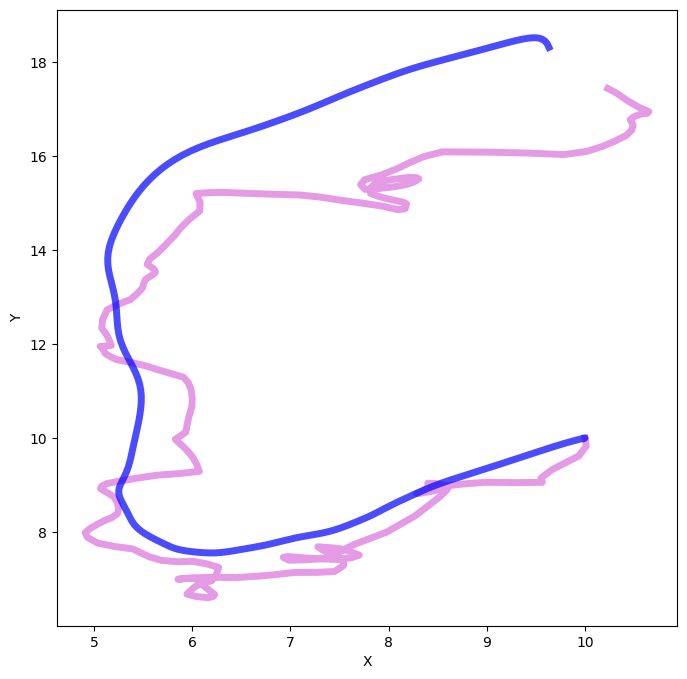

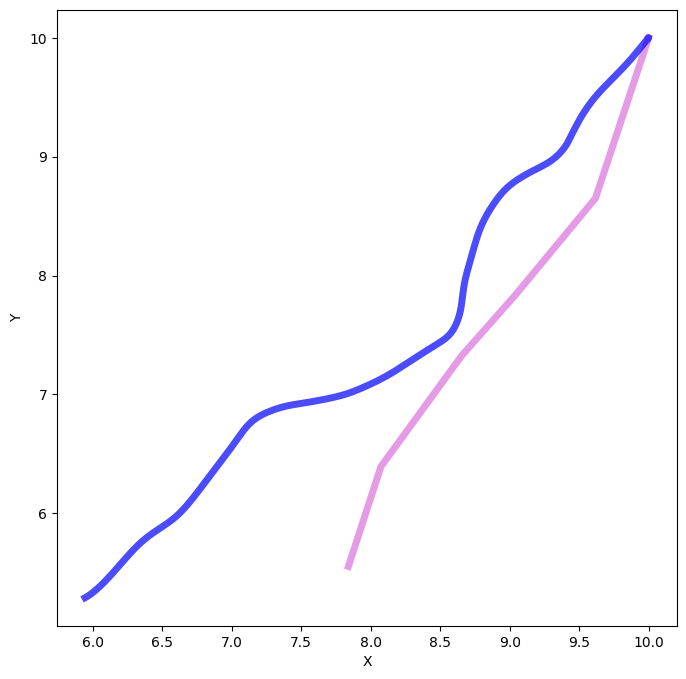

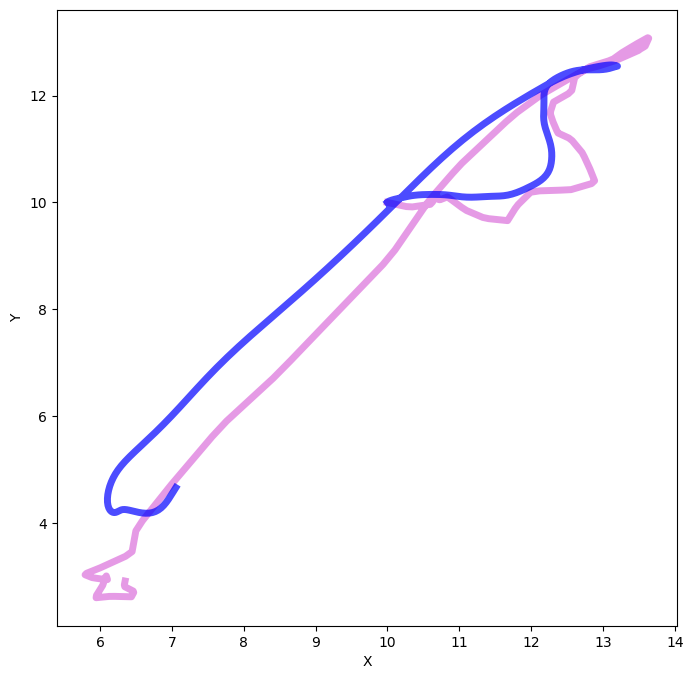

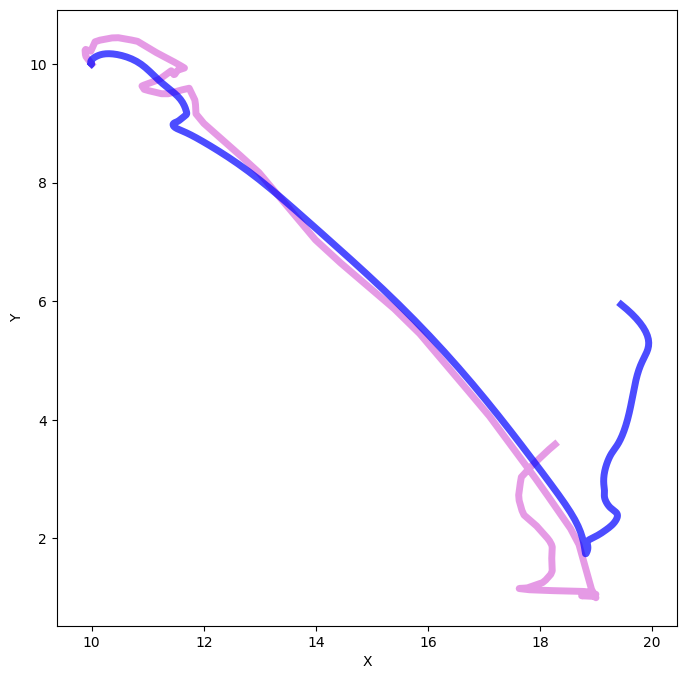

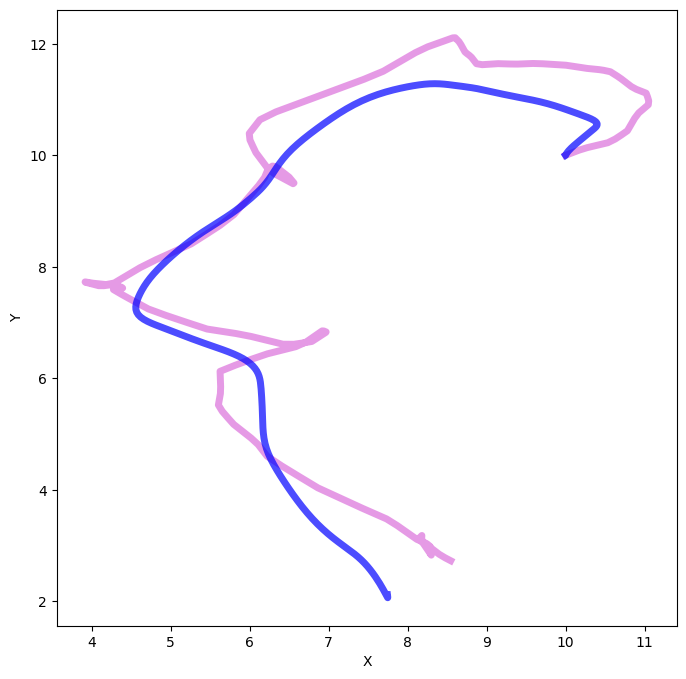

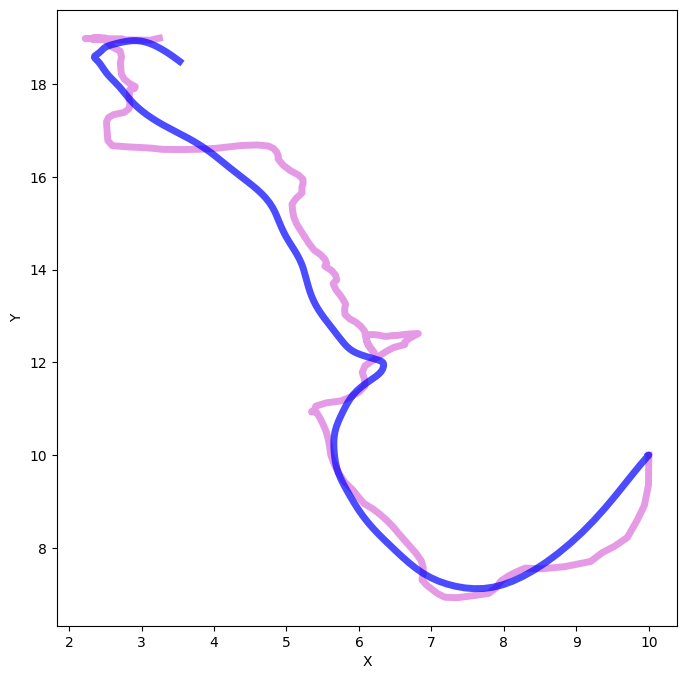

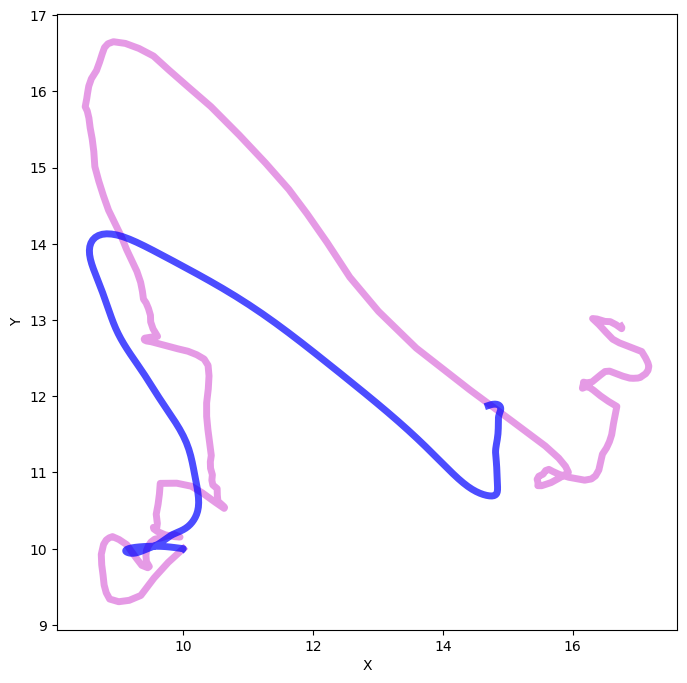

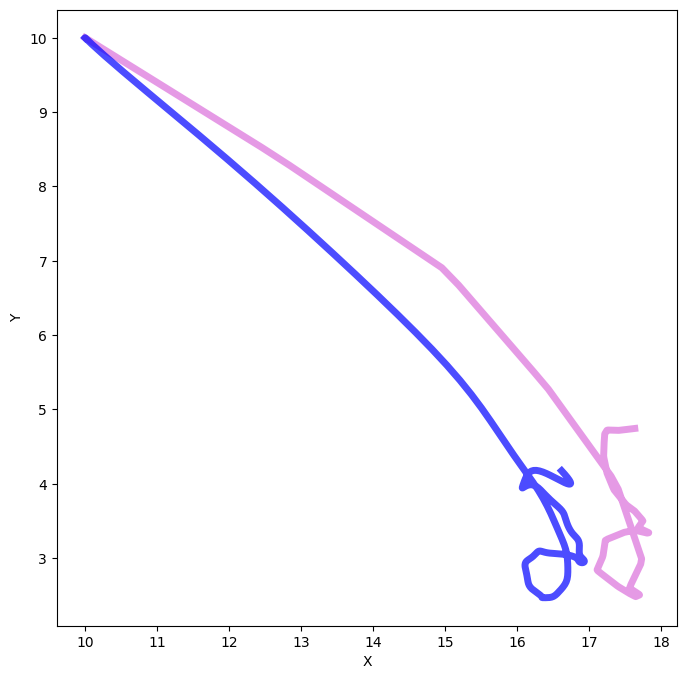

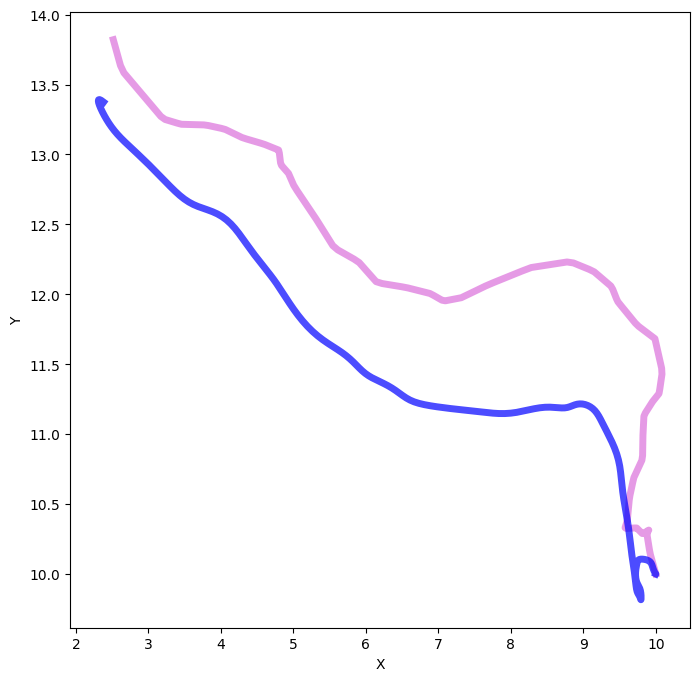

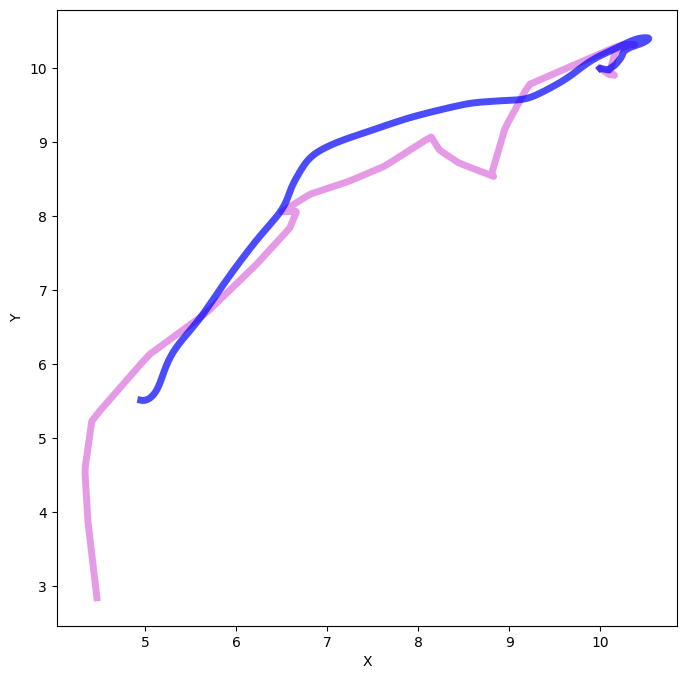

In [51]:


NeuroScribe.eval()

#getgnet.eval()

test_sample_indices = [100,103,104,112,131,132,133,134,175,182]

# goal_t=getgnet(X[test_sample_indices])
y_ht = NeuroScribe(X[test_sample_indices], Y[test_sample_indices, 0, :])
y_rt = Y[test_sample_indices]
#goal_e=getgnet(X[train_sample_indices])

for i in range(0, len(test_sample_indices)):
    plt.figure(figsize=(8, 8))
    plt.tight_layout()

    plt.plot(y_rt[i, :, 0].detach().cpu().numpy(), y_rt[i, :, 1].detach().cpu().numpy(), c='#DB70DB',alpha=0.7, linewidth=5,label='Original Trajectory')
    plt.plot(y_ht[i, :, 0].detach().cpu().numpy(), y_ht[i, :, 1].detach().cpu().numpy(), c='blue',alpha=0.7, linewidth=5,label='Generated Trajectory')
    # plt.xticks([ (i - 1) * 0.05 for i in range(1, 21)])
    # plt.yticks([ (i - 1) * 0.05 for i in range(1, 21)])
    # plt.xticks(range(1,20,1))
    # plt.yticks(range(1,20,1))
    plt.xlabel('X')
    plt.ylabel('Y')

    #plt.show()
    plt.savefig(image_save_path + '/test_img_'  + '_' + str(i) + '.png')

